# double-duel-q-learning-agent

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tf.compat.v1.disable_eager_execution()
sns.set()

In [8]:
df = pd.read_csv('/Users/gkumargaur/workspace/python/gitprojects/Stock-Prediction-Models/dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2020-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2020-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2020-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2020-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [9]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.compat.v1.placeholder(tf.float32, (None, input_size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        feed = tf.compat.v1.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.compat.v1.layers.dense(tensor_action, output_size)
        feed_validation = tf.compat.v1.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(input_tensor=feed_action,axis=1,keepdims=True))
        self.cost = tf.reduce_sum(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.compat.v1.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        self.trainable = tf.compat.v1.trainable_variables()

    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})

    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()

                action = self._select_action(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)

                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y = self._construct_memories(replay)

                cost, _ = self.sess.run([self.model.cost, self.model.optimizer],
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [10]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 1253.809995.3, cost: 1.425192, total money: 9266.630002
epoch: 20, total rewards: 830.399712.3, cost: 1.186912, total money: 10830.399712
epoch: 30, total rewards: 901.305052.3, cost: 0.884960, total money: 3080.835081
epoch: 40, total rewards: 1220.435003.3, cost: 2.839395, total money: 11220.435003
epoch: 50, total rewards: 728.970220.3, cost: 0.598730, total money: 49.460209
epoch: 60, total rewards: 21.449708.3, cost: 0.471072, total money: 4083.979676
epoch: 70, total rewards: 304.100162.3, cost: 0.510502, total money: 8299.260135
epoch: 80, total rewards: 911.095280.3, cost: 1.504493, total money: 8906.255253
epoch: 90, total rewards: 272.805053.3, cost: 0.475075, total money: 10272.805053
epoch: 100, total rewards: 832.840214.3, cost: 0.577908, total money: 10832.840214
epoch: 110, total rewards: 1566.145270.3, cost: 0.609666, total money: 10595.605292
epoch: 120, total rewards: 491.709659.3, cost: 1.458873, total money: 592.029665
epoch: 130, total rew

In [11]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1: buy 1 unit at price 762.130005, total balance 8469.169983
day 2, sell 1 unit at price 762.020020, investment -0.868999 %, total balance 9231.190003,
day 3, sell 1 unit at price 782.520020, investment 2.675399 %, total balance 10013.710023,
day 9: buy 1 unit at price 758.489990, total balance 9255.220033
day 12, sell 1 unit at price 760.539978, investment 0.270272 %, total balance 10015.760011,
day 16: buy 1 unit at price 761.679993, total balance 9254.080018
day 17: buy 1 unit at price 768.239990, total balance 8485.840028
day 18, sell 1 unit at price 770.840027, investment 1.202609 %, total balance 9256.680055,
day 19, sell 1 unit at price 758.039978, investment -1.327712 %, total balance 10014.720033,
day 22: buy 1 unit at price 762.520020, total balance 9252.200013
day 23, sell 1 unit at price 759.109985, investment -0.447206 %, total balance 10011.309998,
day 37: buy 1 unit at price 791.549988, total balance 92

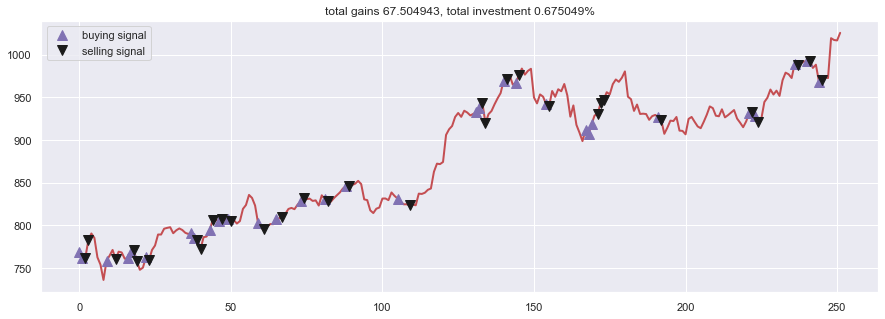

In [12]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()